In [1]:
import os, random, shutil
from pathlib import Path
import cv2
import numpy as np
from PIL import Image

!pip install mtcnn opencv-python

from mtcnn import MTCNN
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 89.1 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

In [5]:
TRAIN_DIR = "/content/drive/MyDrive/AI_Project/experiment/split/train"
VAL_DIR   = "/content/drive/MyDrive/AI_Project/experiment/split/val"
TEST_DIR  = "/content/drive/MyDrive/AI_Project/experiment/split/test"

In [6]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 12340 files belonging to 31 classes.
Found 583 files belonging to 31 classes.
Found 1218 files belonging to 31 classes.


In [7]:
base_model = ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(train_ds.class_names), activation="softmax")
])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [9]:
EPOCHS = 15

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/15
386/386 ━━━━━━━━━━━━━━━━━━━━ 2039s 5s/step - accuracy: 0.4059 - loss: 2.5855 - val_accuracy: 0.7547 - val_loss: 0.9966
Epoch 2/15
386/386 ━━━━━━━━━━━━━━━━━━━━ 42s 108ms/step - accuracy: 0.7572 - loss: 0.8445 - val_accuracy: 0.7633 - val_loss: 0.9961
Epoch 3/15
386/386 ━━━━━━━━━━━━━━━━━━━━ 83s 110ms/step - accuracy: 0.8195 - loss: 0.6061 - val_accuracy: 0.7667 - val_loss: 1.0098
Epoch 4/15
386/386 ━━━━━━━━━━━━━━━━━━━━ 82s 109ms/step - accuracy: 0.8558 - loss: 0.4802 - val_accuracy: 0.7822 - val_loss: 1.0081
Epoch 5/15
386/386 ━━━━━━━━━━━━━━━━━━━━ 42s 109ms/step - accuracy: 0.8803 - loss: 0.3966 - val_accuracy: 0.7822 - val_loss: 1.0058
Epoch 6/15
386/386 ━━━━━━━━━━━━━━━━━━━━ 41s 107ms/step - accuracy: 0.8937 - loss: 0.3490 - val_accuracy: 0.7873 - val_loss: 1.0771
Epoch 7/15
386/386 ━━━━━━━━━━━━━━━━━━━━ 41s 107ms/step - accuracy: 0.8896 - loss: 0.3555 - val_accuracy: 0.7942 - val_loss: 1.1441
Epoch 8/15
386/386 ━━━━━━━━━━━━━━━━━━━━ 41s 107ms/step - accuracy: 0.9105 - loss: 0.

In [10]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy:", test_acc)


39/39 ━━━━━━━━━━━━━━━━━━━━ 214s 5s/step - accuracy: 0.8228 - loss: 1.0335
Test accuracy: 0.8119868636131287


In [11]:
import numpy as np

# predictions (probabilities لكل class)
y_pred_prob = model.predict(test_ds)
y_pred = np.argmax(y_pred_prob, axis=1)  # multi-class

# true labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)


39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 204ms/step


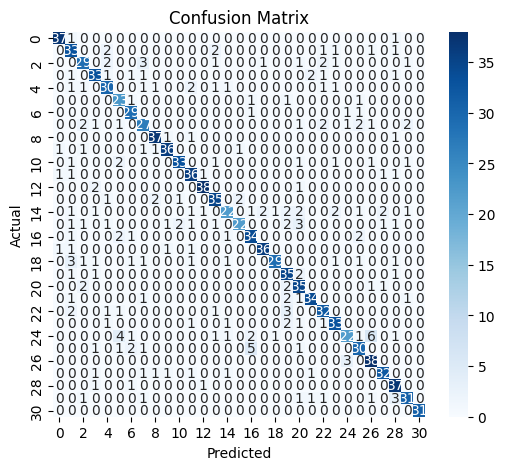

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [13]:
from sklearn.metrics import classification_report

print("Classification Report:\n")
print(classification_report(y_true, y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.95      0.94        39
           1       0.67      0.80      0.73        41
           2       0.76      0.71      0.73        41
           3       0.79      0.80      0.80        41
           4       0.77      0.75      0.76        40
           5       0.68      0.85      0.75        27
           6       0.78      0.91      0.84        32
           7       0.71      0.68      0.69        40
           8       0.88      0.93      0.90        40
           9       0.90      0.88      0.89        41
          10       0.92      0.80      0.86        41
          11       0.80      0.88      0.84        41
          12       0.93      0.93      0.93        41
          13       0.81      0.85      0.83        41
          14       0.79      0.55      0.65        40
          15       0.88      0.59      0.71        37
          16       0.77      0.83      0.80        41
   

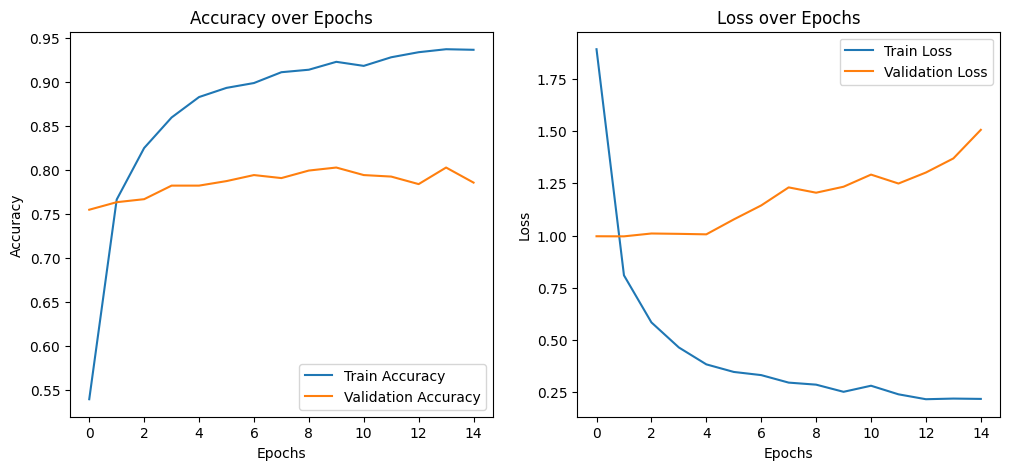

In [14]:
import matplotlib.pyplot as plt

# رسم Accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# رسم Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
